In [25]:
pip install selenium beautifulsoup4 pandas

Note: you may need to restart the kernel to use updated packages.


In [26]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

In [27]:
# Set up Selenium WebDriver
chromedriver_path = r'C:\Users\91933\OneDrive\Desktop\yatra_webscraping\chromedriver-win64\chromedriver.exe'  # Update with the actual path to your ChromeDriver
service = Service(chromedriver_path)
driver = webdriver.Chrome(service=service)



In [28]:
# URL to navigate
url = "https://flight.yatra.com/air-search-ui/int2/trigger?flex=0&viewName=normal&source=fresco-flights&type=O&class=Economy&ADT=1&CHD=0&INF=0&noOfSegments=1&origin=DEL&originCountry=IN&destination=DXB&destinationCountry=AE&flight_depart_date=18/01/2025&arrivalDate="


In [29]:
# Open the URL and wait for the page to load
driver.get(url)
time.sleep(29)  # Adjust sleep time based on internet speed

# Get the page source and close the browser
html_content = driver.page_source
driver.quit()

# Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

# Initialize a list to store flight data
flight_data = []

# Locate all flight details containers (modify the selector if needed)
flight_containers = soup.find_all('div', class_='airline-holder clearfix')

In [30]:
# Extract data for each flight
for container in flight_containers:
    # Extract flight name
    airline_name_tag = container.find('div', class_='full mb-8 fs-13 airline-name')
    airline_name = airline_name_tag.find('span', class_='text i-b').text.strip() if airline_name_tag else 'N/A'

    # Extract departure time, airport, and city
    departure_tag = container.find_next('div', class_='i-b col-4 no-wrap text-right dtime')
    departure_time = departure_tag.find('p', class_='fs-16 bold mb-2 time') if departure_tag else None
    departure_time = departure_time.text.split()[-1].strip() if departure_time else 'N/A'  # Extract time only
    departure_airport = departure_tag.find('p', class_='fs-11 font-lightgrey no-wrap city ellipsis').text.strip() if departure_tag else 'N/A'

    # Extract arrival time, airport, and city
    arrival_tag = container.find_next('div', class_='i-b col-5 pdd-0 text-left atime')
    arrival_time_element = arrival_tag.find('p', class_='bold fs-16 mb-2 pr time') if arrival_tag else None
    
    if arrival_time_element:
        # Extract the main time text
        arrival_time_text = arrival_time_element.text.strip()
        
        # Remove "+0 Day" or "+1 Day" from the text
        arrival_time_text = re.sub(r'\s*\+\d+\s*Day', '', arrival_time_text).strip()
        
        # Extract only the time portion (e.g., "21:50" from "21:50DXB")
        arrival_time = re.match(r'^\d{2}:\d{2}', arrival_time_text)
        arrival_time = arrival_time.group(0) if arrival_time else 'N/A'
    else:
        arrival_time = 'N/A'
    
    arrival_airport = arrival_tag.find('p', class_='fs-11 font-lightgrey no-wrap city ellipsis').text.strip() if arrival_tag else 'N/A'

    # Extract flight duration
    duration_tag = container.find_next('p', class_='fs-12 bold du mb-2')
    flight_duration = duration_tag.text.strip() if duration_tag else 'N/A'

    # # Extract stops
    # stops_tag = container.find_next('span', class_='dotted-borderbtm')
    # stops = stops_tag.text.strip() if stops_tag else 'N/A'

    # Extracting Stops
    stops_tag = container.find_next('span', {'ng-class': "{'dotted-borderbtm':leg.stops>0}"})
    if stops_tag:
        stops_text = stops_tag.text.strip()
        if "Non Stop" in stops_text:
            stops = "0 Stops"
        elif "1 Stop" in stops_text:
            stops = "1 Stop"
        elif "2 Stops" in stops_text:
            stops = "2 Stops"
        else:
            stops = "N/A"
    else:
        stops = "N/A"


    # Extract price
    price_tag = container.find_next('p', class_='i-b', id=True)
    price = price_tag.text.strip() if price_tag else 'N/A'
    price = re.sub(r'\D', '', price)  # Remove non-numeric characters from price

    # Append the extracted data to the list
    flight_data.append({
        'Airline': airline_name,
        'Departure Time': departure_time,
        'Departure Airport': departure_airport,
        'Arrival Time': arrival_time ,
        'Arrival Airport': arrival_airport,
        'Flight Duration': flight_duration,
        'Stops': stops,
        'Price': price
    })



In [31]:
# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(flight_data)



In [32]:
# Save the data to a CSV file
x=df.to_csv('flight_data.csv', index=False)



In [33]:
# Display the first few rows of the DataFrame
print(df.head())

      Airline Departure Time Departure Airport Arrival Time Arrival Airport  \
0      IndiGo          19:00         New Delhi        14:35         Sharjah   
1  Air Arabia          18:20         New Delhi        20:50         Sharjah   
2      IndiGo          21:30         New Delhi        00:55         Sharjah   
3      IndiGo          07:55         New Delhi        13:25       Abu Dhabi   
4      IndiGo          18:45         New Delhi        03:10       Abu Dhabi   

  Flight Duration    Stops    Price  
0         21h 05m   1 Stop  2623100  
1          4h 00m  0 Stops  2688400  
2         28h 55m   1 Stop  2826700  
3          7h 00m   1 Stop  2968800  
4          9h 55m   1 Stop  2972300  


In [34]:
df.head(x)

,Airline,Departure Time,Departure Airport,Arrival Time,Arrival Airport,Flight Duration,Stops,Price
0,IndiGo,19:00,New Delhi,14:35,Sharjah,21h 05m,1 Stop,2623100
1,Air Arabia,18:20,New Delhi,20:50,Sharjah,4h 00m,0 Stops,2688400
2,IndiGo,21:30,New Delhi,00:55,Sharjah,28h 55m,1 Stop,2826700
3,IndiGo,07:55,New Delhi,13:25,Abu Dhabi,7h 00m,1 Stop,2968800
4,IndiGo,18:45,New Delhi,03:10,Abu Dhabi,9h 55m,1 Stop,2972300
...,...,...,...,...,...,...,...,...
92,Qatar Airways,03:40,New Delhi,10:15,Sharjah,8h 05m,1 Stop,12821700
93,Qatar Airways,03:40,New Delhi,20:25,Sharjah,18h 15m,1 Stop,12844300
94,Srilankan Airlines,18:35,New Delhi,15:55,Sharjah,22h 50m,2 Stops,13531500
95,Srilankan Airlines,18:35,New Delhi,20:25,Sharjah,27h 20m,2 Stops,15190500


In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Airline            97 non-null     object
 1   Departure Time     97 non-null     object
 2   Departure Airport  97 non-null     object
 3   Arrival Time       97 non-null     object
 4   Arrival Airport    97 non-null     object
 5   Flight Duration    97 non-null     object
 6   Stops              97 non-null     object
 7   Price              97 non-null     object
dtypes: object(8)
memory usage: 6.2+ KB
None


In [36]:
!pip install pandas matplotlib seaborn plotly.express

Data Preprocessing

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np


In [38]:
# Converting the 'Price' column to numeric and scale correctly
df['Price'] = pd.to_numeric(df['Price']) / 100

# Extract hours and minutes for duration
df['Duration Hours'] = df['Flight Duration'].str.extract(r'(\d+)h').astype(float)
df['Duration Minutes'] = df['Flight Duration'].str.extract(r'(\d+)m').astype(float)
df['Total Duration (Minutes)'] = df['Duration Hours'] * 60 + df['Duration Minutes']



In [39]:
# Count the number of stops
df['Stops Count'] = df['Stops'].str.extract(r'(\d+)').astype(int)

# Data cleanup for time columns
df['Departure Time'] = pd.to_datetime(df['Departure Time'], format='%H:%M').dt.time
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M').dt.time

Data Visualization

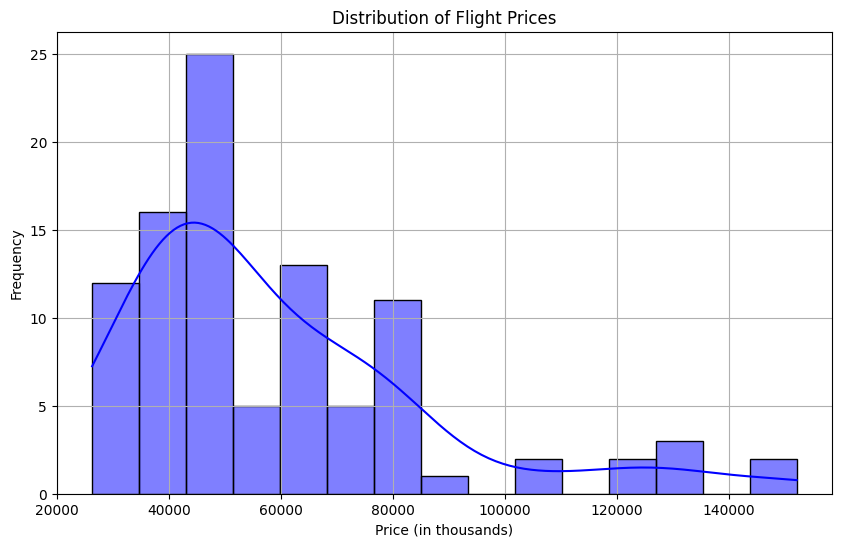

In [40]:
#  Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=15, color='blue')
plt.title('Distribution of Flight Prices')
plt.xlabel('Price (in thousands)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

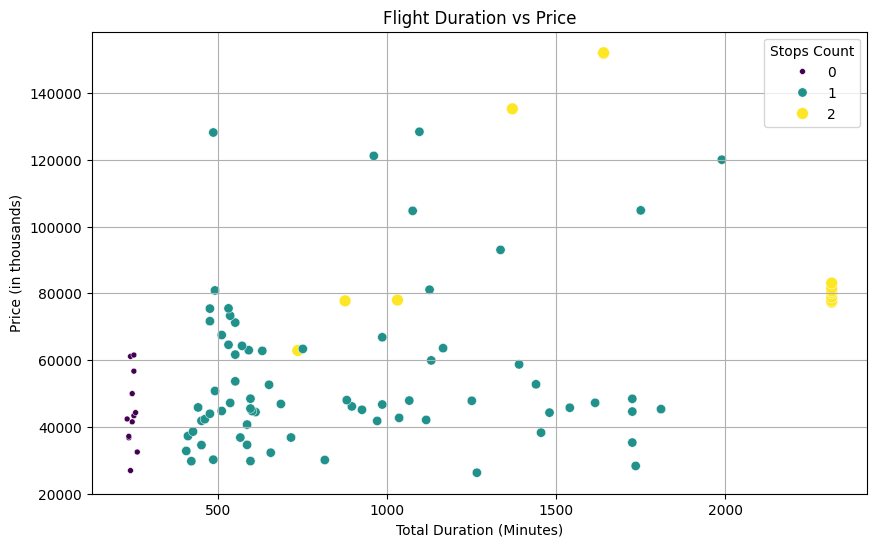

In [41]:
# Flight Duration vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total Duration (Minutes)', y='Price', hue='Stops Count', size='Stops Count', palette='viridis')
plt.title('Flight Duration vs Price')
plt.xlabel('Total Duration (Minutes)')
plt.ylabel('Price (in thousands)')
plt.grid(True)
plt.legend(title='Stops Count')
plt.show()


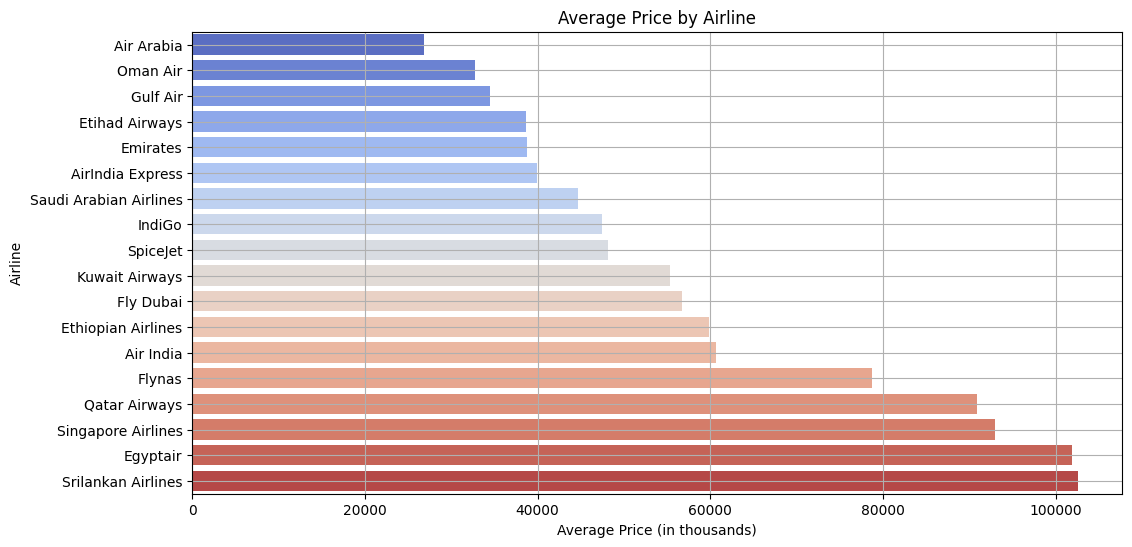

In [42]:
#Average Price by Airline
plt.figure(figsize=(12, 6))
airline_avg_price = df.groupby('Airline')['Price'].mean().sort_values()
sns.barplot(y=airline_avg_price.index, x=airline_avg_price, hue=airline_avg_price.index, dodge=False, palette='coolwarm', legend=False)
plt.title('Average Price by Airline')
plt.xlabel('Average Price (in thousands)')
plt.ylabel('Airline')
plt.grid(True)
plt.show()


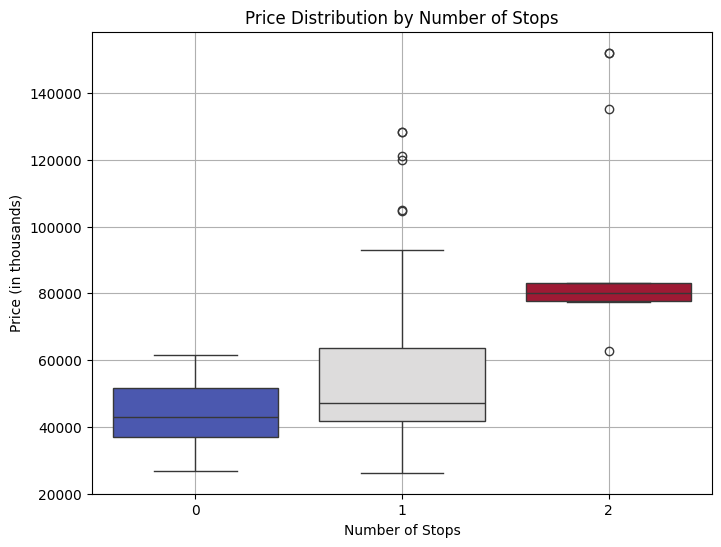

In [43]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Stops Count', y='Price', hue='Stops Count', dodge=False, palette='coolwarm', legend=False)
plt.title('Price Distribution by Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Price (in thousands)')
plt.grid(True)
plt.show()


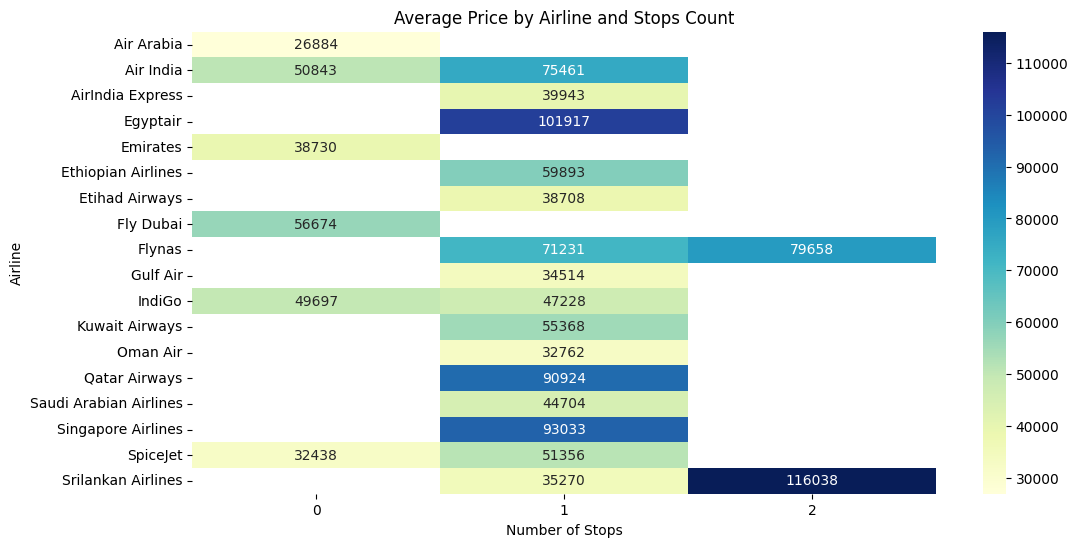

In [44]:
# 6. Heatmap of Average Price by Airline and Stops
pivot_table = df.pivot_table(values='Price', index='Airline', columns='Stops Count', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Average Price by Airline and Stops Count')
plt.xlabel('Number of Stops')
plt.ylabel('Airline')
plt.show()


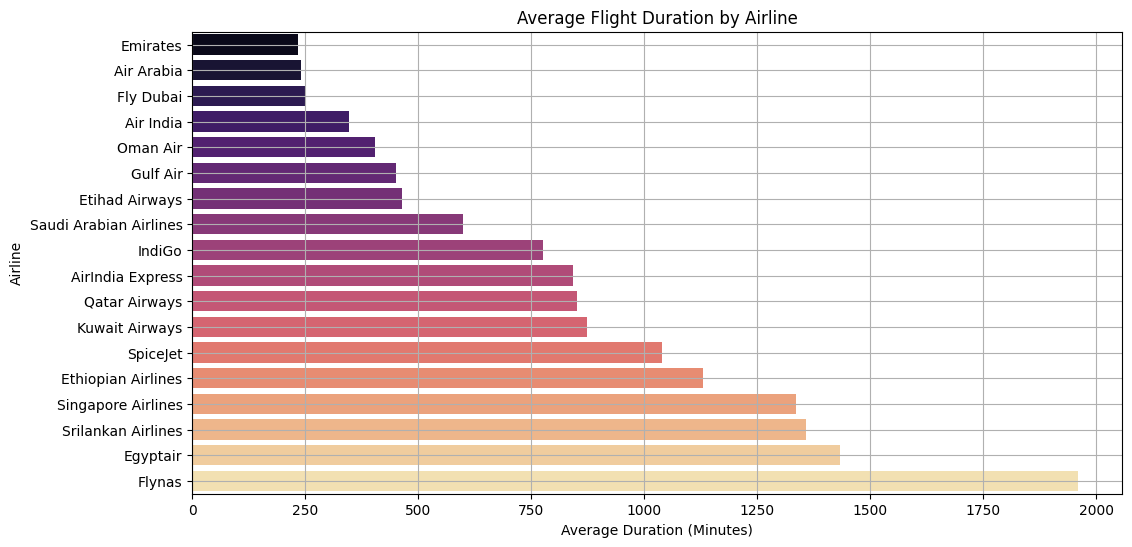

In [45]:
plt.figure(figsize=(12, 6))
airline_avg_duration = df.groupby('Airline')['Total Duration (Minutes)'].mean().sort_values()
sns.barplot(y=airline_avg_duration.index, x=airline_avg_duration, hue=airline_avg_duration.index, dodge=False, palette='magma', legend=False)
plt.title('Average Flight Duration by Airline')
plt.xlabel('Average Duration (Minutes)')
plt.ylabel('Airline')
plt.grid(True)
plt.show()


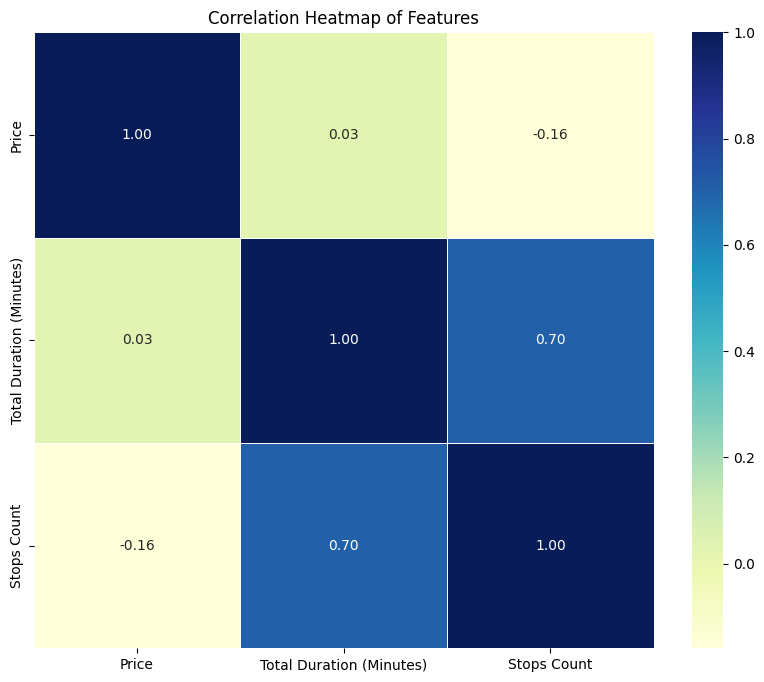

In [46]:
# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()